# Single Experiment Data Cut

## Library Import

In [79]:
from nptdms import TdmsFile
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math
import json
import numpy as np
from scipy.stats import linregress

## Loading CSV Data

In [80]:
vtoinch = 0.17153
vtoIL_coarse = 1280 #high stresses or very cold conditions
vtoIL_fine = 202
sample_r = 0.55
R = 0.0083145 #KJ/mol
Q_DC = 181 # Dislocation Creep Activation Energy (KJ/mol)
Q_GBS = 192 # activation energy >255 (KJ/mol)

# EMS Data
col_EMS = ['Experiment Number', 'Date', 'Target Temperature', 'Grain Size', 
    'Target Strain Rate', 'Initial Length', 'Final Length', 
    'Target Pressure', 'Internal Axial Load Read', 'Storage', 'Exp Start',
     'Exp Finish', 'Regime','Operator','Notes']
exp_EMS = pd.read_csv (r'D:\ICE\EMS\EMS.csv', names = col_EMS, skiprows=1)
exp_loc = 13

i = exp_EMS['Experiment Number'][exp_loc]
L0 = exp_EMS['Initial Length'][exp_loc] # Original Sample Lenght
SR_exp = exp_EMS['Target Strain Rate'][exp_loc] # Target Strain Rate
GS_exp = exp_EMS['Grain Size'][exp_loc] # Grain Size (Coarse, Standard or Fine)
temp_target = exp_EMS['Target Temperature'][exp_loc]
pressure_target = exp_EMS['Target Pressure'][exp_loc]
start = exp_EMS['Exp Start'][exp_loc]
finish = exp_EMS['Exp Finish'][exp_loc]
regime = exp_EMS['Regime'][exp_loc]
notes = exp_EMS['Notes'][exp_loc]

col_EXP = ['Date', 'Time', 'Pressure', 'Temperature', 'Internal Load', 'External Load', 'Displacement', 'Intensifier', '6v', 'Bath Temperature', 'Piston13', 'Piston20']
exp_data = pd.read_csv (f'D:\Ice Data Master Folder\PIL{i}.csv', names = col_EXP, skiprows = 2)
temp = np.array(exp_data['Temperature'])
IL = np.array(exp_data['Internal Load'])
disp = np.array(exp_data['Displacement'])
raw_time = np.array(exp_data['Time'])

sec_list = []
time = []
for row in raw_time:
    sec_list = row[:-3]
    ftr = [3600,60,1]

    if row[-2:] == 'PM' and row[0:2] != '12':
        sec = 43200 + sum([a*b for a,b in zip(ftr, map(int,sec_list.split(':')))])
    else:
        sec = sum([a*b for a,b in zip(ftr, map(int,sec_list.split(':')))])
    time.append(sec)

Lf_raw = L0 - disp * vtoinch
stress_raw = IL * vtoIL_fine * Lf_raw / (sample_r**2 * math.pi * L0)
strain_raw = np.log(L0 / Lf_raw)

## Cutting the Data

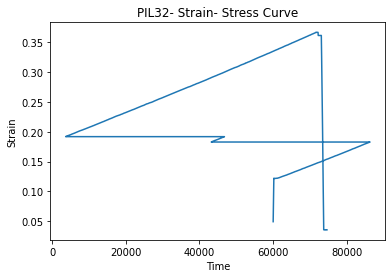

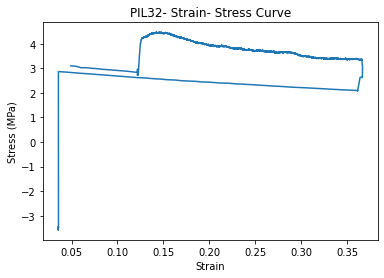

In [81]:
plt.plot(time,strain_raw)
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'PIL{i}- Strain- Stress Curve')
plt.show()

plt.plot(strain_raw,stress_raw)
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title(f'PIL{i}- Strain- Stress Curve')
plt.show()

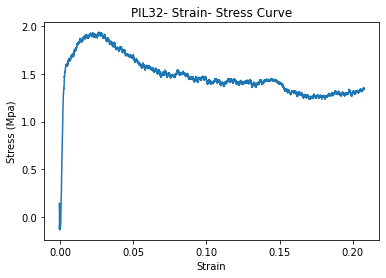

In [82]:
#start = [n for n,i in enumerate(time) if i> 45200][0]
#finish = [n for n,i in enumerate(time) if i> 46200][0]

start = [n for n,i in enumerate(strain_raw) if i> 0.120][0]
finish = [n for n,i in enumerate(strain_raw) if i> 0.36][0]

Lf_raw = L0 - (disp[start:finish] - disp[start]) * vtoinch
stress = ((IL[start:finish] * vtoIL_fine * Lf_raw / (sample_r**2 * math.pi * L0))-(IL[start] * vtoIL_fine * Lf_raw / (sample_r**2 * math.pi * L0)))
strain = np.log(L0 / Lf_raw)

plt.plot(strain, stress)
plt.xlabel('Strain')
plt.ylabel('Stress (Mpa)')
plt.title(f'PIL{i}- Strain- Stress Curve')
plt.show()

## Peak and Flow Strain & Strain

In [83]:
stress_peak_loc = np.argmax(stress)
stress_peak = stress[stress_peak_loc]
strain_peak = strain[stress_peak_loc]
temp_peak = temp[stress_peak_loc]
slopeSR, interceptSR, r_valueSR, p_valueSR, std_errSR = linregress (time[start:finish],strain) # lin regress over all data
SR_peak = slopeSR *  np.exp((- Q_GBS / R) * ((1/temp_target)-(1/temp_peak))) # with correction
stress_flow = np.mean(stress[-10:-1])
SR_flow = slopeSR *  np.exp((- Q_GBS / R) * ((1/temp_target)-(1/np.mean(temp[(finish-10):finish]))))

print('Peak Stress = ', stress_peak, 'Peak Strain =', strain_peak)

Peak Stress =  1.9352567746382636 Peak Strain = 0.026806740501351872


## Creating JSON

In [84]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [85]:
dict = {'Experiment': i, 'L0': L0, 'Strain Rate Exp': SR_exp, 'Grain Size': GS_exp, 'Temperature Exp': temp_target, 'Pressure Exp': pressure_target,
            'Temperature':temp[start:finish], 
            'Internal Load':IL[start:finish], 
            'Displacement':time[start:finish],
            'Seconds': time[start:finish], 
            'Stress': stress,
            'Strain': strain, 
            'Stress Peak': stress_peak,
            'Stress Flow': stress_flow,
            'Strain Rate Peak': SR_peak,
            'Strain Rate Flow':  SR_flow,
            'Regime': regime,
            'Notes':notes}

with open(f'PIL{i}.json', 'w') as fp:
    json.dump(dict, fp, cls=NumpyEncoder)

Text(0, 0.5, 'Stress (MPa)')

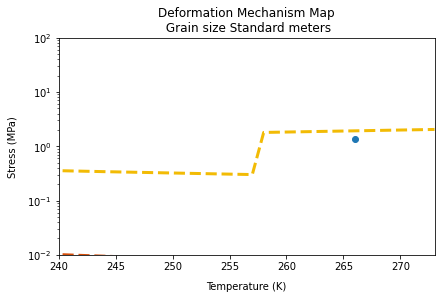

In [86]:
if GS_exp == 'Coarse':
    d = 360e-06 # meters
elif GS_exp == 'Standard':
    d = 230e-06
else:
    d = 10e-06

# Dislocation Creep Parameters
A_DC257 = 1.2e+06 # A <258 (MPa^-4 s^-1) updated form Kuiper 2019 4e+05 original value
A_DC259 = 6e+28 # A >258 (MPa^-4 s^-1)
n_DC = 4 # stress exponent
p_DC = 0 # grain size exponent
Q_DC257 = 60 # activation energy <258 (KJ/mol)
Q_DC259 = 181 # activation energy >258 (KJ/mol)

# GBS Parameters
A_GBS254 = 3.9e-03 # A <258 (MPa^-1.8 m^1.4 s^-1)
A_GBS256 = 3e+26 # A >258 (MPa^-1.8 m^1.4 s^-1)
n_GBS = 1.8 # stress exponent
p_GBS = 1.4 # grain size exponent
Q_GBS254 = 49 # activation energy <255 (KJ/mol)
Q_GBS256 = 192 # activation energy >255 (KJ/mol)

# Basal Slip Parameters
A_BS = 5.5e+07 # A
n_BS = 2.4 # stress exponent
p_BS = 0 # grain size exponent
Q_BS = 60 # activation energy <258 (KJ/mol)

# Other Parameters
R = 0.0083145 # gas constant (KJ/mol K)
EE = 9100 # Ice Young's Modulus (MPa)

# temperature
temp_warm = pd.Series(np.arange(258,274,1)) #temperature series from 273 to 150
temp_cold = pd.Series(np.arange(100,258,1))

for row in temp_warm:
    DCGBS = []
    GBSBS = []

    # Individual Mechanims
    boundary_DC = A_DC259 * np.exp ((-Q_DC259)/ (R * temp_warm)) / (d ** p_DC)
    boundary_GBS = A_GBS256 * np.exp ((-Q_GBS256)/ (R * temp_warm)) / (d ** p_GBS)
    boundary_BS = A_BS * np.exp ((-Q_BS)/ (R * temp_warm)) / (d ** p_BS)

    #Boundaries 
    boundary_DCGBS259 = (boundary_GBS / boundary_DC) ** (1 / (n_DC/n_GBS))
    boundary_GBSBS259 = (boundary_GBS / boundary_BS) ** (1 / (n_BS/n_GBS))
    DCGBS.append(boundary_DCGBS259)
    GBSBS.append(boundary_GBSBS259)

for row in temp_cold:   
    # Individual Mechanims
    boundary_DC = A_DC257 * np.exp ((-Q_DC257)/ (R * temp_cold)) / (d ** p_DC)
    boundary_GBS = A_GBS254 * np.exp ((-Q_GBS254)/ (R * temp_cold)) / (d ** p_GBS)
    boundary_BS = A_BS * np.exp ((-Q_BS)/ (R * temp_cold)) / (d ** p_BS)

    #Boundaries 
    boundary_DCGBS257 = (boundary_GBS / boundary_DC) ** (1 / (n_DC/n_GBS))
    boundary_GBSBS257 = (boundary_GBS / boundary_BS) ** (1 / (n_BS/n_GBS))
    DCGBS.append(boundary_DCGBS257)
    GBSBS.append(boundary_GBSBS257)

# Series Append - unsure what is not working of DCGBS
temp = temp_cold.append(temp_warm)
boundI = boundary_DCGBS257.append(boundary_DCGBS259) #dislocation creep - GBS
boundII = boundary_GBSBS257.append(boundary_GBSBS259) # GBS - basal slip
GBSTextLoc = ((boundI[155]-boundII[155])/2)

# Deformation Map Plot
fig, ax = plt.subplots(constrained_layout=True)

#Plotting 
ax.plot(temp, boundI, color='#F2BB05', linestyle='dashed', linewidth=3)
ax.plot(temp_cold, boundary_GBSBS257, color='#D74E09', linestyle='dashed', linewidth=3) ## BS breaks at high temperatures
ax.plot(temp_target, stress_flow, marker='o')
ax.set_title(f'Deformation Mechanism Map\n Grain size {GS_exp} meters')

ax.set_xlabel('Temperature (K)', labelpad=10)
ax.set_ylim(10e-3, 10e+1)
ax.set_xlim(240, 273)
plt.yscale("log")
ax.set_ylabel('Stress (MPa)', labelpad=10)